<DIV ALIGN=CENTER>

# Introduction to General Linear Models
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we build on 

-----



In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----
### Test Data

-----

In [2]:
# Some common definitions
n_samples = 10000
n_burn = n_samples / 2

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25
    gamma = 0.2

    if params:
        alpha = params['Intercept']
        beta = params['x']
        gamma = params['np.power(x, 2)']

    return (alpha + beta * x  + gamma * x **2)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

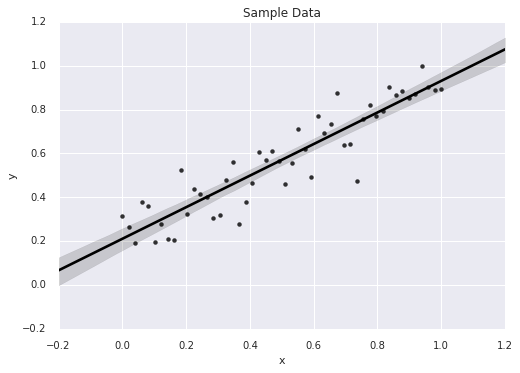

In [3]:
# Obtain sample data and plot data and model fit

x, y = randomizeModel(num = 50)

df = pd.DataFrame({'x': x, 'y': y})

ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----

## GLM

-----

In [4]:
import pymc3 as pm

with pm.Model() as model_glm:
    pm.glm.glm('y ~ x', df)
    trace = pm.sample(n_samples)

Applied log-transform to sd and added transformed sd_log to model.
Assigned NUTS to Intercept
Assigned NUTS to x
Assigned NUTS to sd_log
 [-----------------100%-----------------] 10000 of 10000 complete in 12.2 sec

-----
### Analyze Results

-----

In [5]:
print(pm.summary(trace, ['Intercept', 'x']))


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.210            0.028            0.000            [0.156, 0.264]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.156          0.192          0.211          0.229          0.265


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.721            0.049            0.001            [0.623, 0.814]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.625          0.689          0.720          0.752          0.816

None


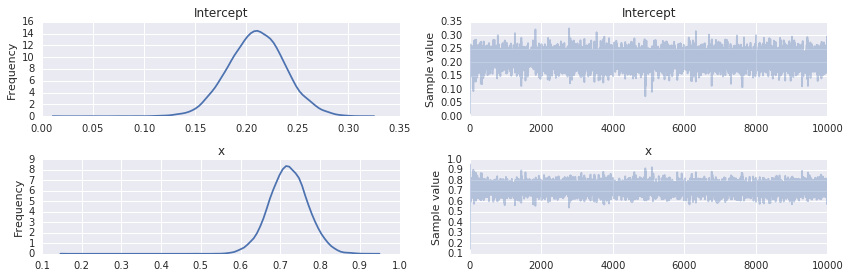

In [6]:
pm.traceplot(trace, ['Intercept', 'x'])
plt.show()

-----
### Visualize Results

-----

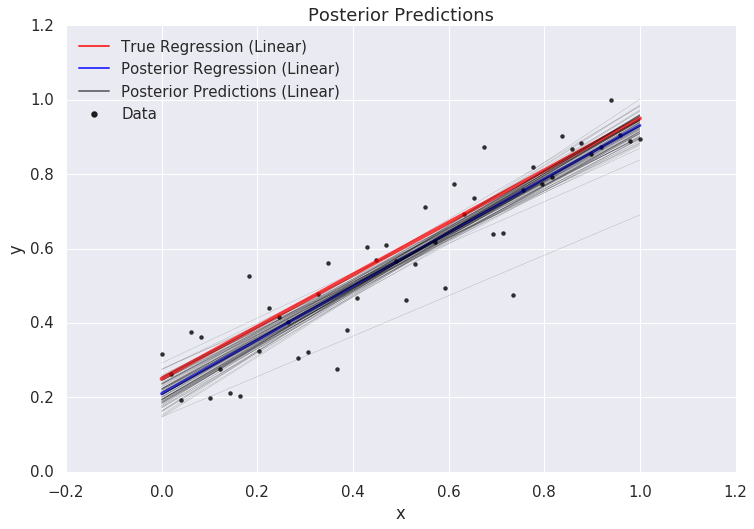

In [7]:
# Set up plot
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)

# plot the data
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(0.0, 1.0, 2)
y_sample = theModel(x_sample)
plt.plot(x_sample, y_sample, color='r', lw=4, alpha = 0.75, \
         label='True Regression (Linear)')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = 0.0

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
         label='Posterior Regression (Linear)')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, eval = x_sample, alpha=0.5,
                              label='Posterior Predictions (Linear)')

# Decorate plot
plt.title('Posterior Predictions')
lgnd = plt.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)
    
plt.xlabel('x')
plt.ylabel('y')

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Non-linear equation

-----

In [8]:
# Patsy doesn't recognize Python power operator **, so we use np.power.

with pm.Model() as model_glm2:
    pm.glm.glm('y ~ x + np.power(x, 2)', df)
    trace = pm.sample(n_samples)

Applied log-transform to sd and added transformed sd_log to model.
Assigned NUTS to Intercept
Assigned NUTS to x
Assigned NUTS to np.power(x, 2)
Assigned NUTS to sd_log
 [-----------------100%-----------------] 10000 of 10000 complete in 23.9 sec

-----
### Analyze Results

-----

In [9]:
print(pm.summary(trace, ['Intercept', 'x', 'np.power(x, 2)']))


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.238            0.040            0.001            [0.158, 0.316]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.159          0.212          0.238          0.264          0.317


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.551            0.186            0.004            [0.164, 0.903]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.177          0.427          0.551          0.672          0.920


np.power(x, 2):

  Mean             SD               MC Error         95% HPD interval
  ----------------

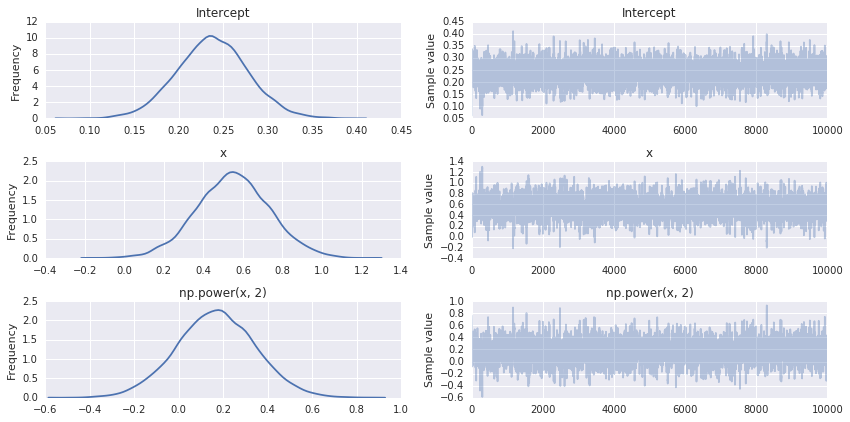

In [10]:
pm.traceplot(trace, ['Intercept', 'x', 'np.power(x, 2)'])
plt.show()

-----

### Visualize Results

-----

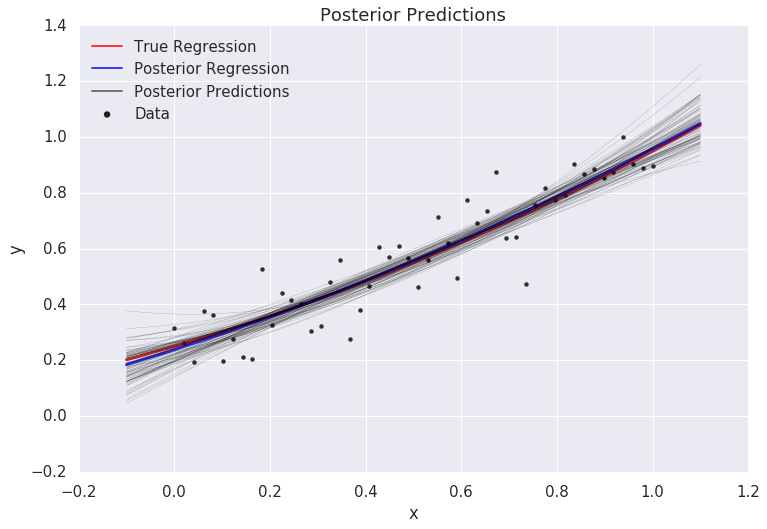

In [11]:
# Set up plot
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)

# plot the data
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(-0.1, 1.1, 100)
y_sample = theModel(x_sample)
plt.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75, \
         label='True Regression')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = np.mean(trace['np.power(x, 2)'][-n_burn:])

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
         label='Posterior Regression')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, \
                                 eval = x_sample, lm = theModel, \
                                 alpha=0.5, label='Posterior Predictions')

# Decorate plot
plt.title('Posterior Predictions')
lgnd = plt.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)
    
plt.xlabel('x')
plt.ylabel('y')

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced ... . Now
that you have run the Notebook, go back and make the following changes
to see how the results change.

1. Change 
2. Replace 
3. Try using 

-----